In [1]:
import glob
import os
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
import time
from sklearn.model_selection import StratifiedKFold
from tensorflow.keras.models import load_model
import natsort

In [2]:
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
physical_gpu = tf.config.list_physical_devices('GPU')
print(len(physical_gpu))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 41827493269206566
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14475013627281526652
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3049888155
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6316983473352530843
physical_device_desc: "device: 0, name: GeForce GTX 1650, pci bus id: 0000:08:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5749950694332151846
physical_device_desc: "device: XLA_GPU device"
]
1


In [3]:
# dt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score
import pydotplus
from sklearn.tree import export_graphviz
from IPython.core.display import Image

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [4]:
seed = 0
tf.random.set_seed(seed)

model_metrics = 'acc'    # acc, mse, mae (epoch마다 표시)
num_epochs = 10
num_batch = 100
num_split = 0.2

In [5]:
#existing
V_path= 'D:/sensors journal/TT_V/train/existing/txt'
V_files = glob.glob(os.path.join(V_path, "*.txt"))
V_files = natsort.natsorted(V_files)
print(V_files)
V_each_file = (pd.read_csv(f, header=None, sep = "\t") for f in V_files)

['D:/sensors journal/TT_V/train/existing/txt\\1.txt', 'D:/sensors journal/TT_V/train/existing/txt\\2.txt', 'D:/sensors journal/TT_V/train/existing/txt\\3.txt', 'D:/sensors journal/TT_V/train/existing/txt\\4.txt', 'D:/sensors journal/TT_V/train/existing/txt\\5.txt', 'D:/sensors journal/TT_V/train/existing/txt\\6.txt', 'D:/sensors journal/TT_V/train/existing/txt\\7.txt', 'D:/sensors journal/TT_V/train/existing/txt\\8.txt', 'D:/sensors journal/TT_V/train/existing/txt\\9.txt', 'D:/sensors journal/TT_V/train/existing/txt\\10.txt', 'D:/sensors journal/TT_V/train/existing/txt\\11.txt', 'D:/sensors journal/TT_V/train/existing/txt\\12.txt', 'D:/sensors journal/TT_V/train/existing/txt\\13.txt', 'D:/sensors journal/TT_V/train/existing/txt\\14.txt', 'D:/sensors journal/TT_V/train/existing/txt\\15.txt', 'D:/sensors journal/TT_V/train/existing/txt\\16.txt', 'D:/sensors journal/TT_V/train/existing/txt\\17.txt', 'D:/sensors journal/TT_V/train/existing/txt\\18.txt', 'D:/sensors journal/TT_V/train/exist

In [6]:
#test 데이터
test_V_path= 'D:/sensors journal/TT_V/test/existing/txt'
test_V_files = glob.glob(os.path.join(test_V_path, "*.txt"))
test_V_files = natsort.natsorted(test_V_files)
print(test_V_files)
test_V_each_file = (pd.read_csv(f, header=None, sep = "\t") for f in test_V_files)

['D:/sensors journal/TT_V/test/existing/txt\\1.txt', 'D:/sensors journal/TT_V/test/existing/txt\\2.txt', 'D:/sensors journal/TT_V/test/existing/txt\\3.txt', 'D:/sensors journal/TT_V/test/existing/txt\\4.txt', 'D:/sensors journal/TT_V/test/existing/txt\\5.txt', 'D:/sensors journal/TT_V/test/existing/txt\\6.txt', 'D:/sensors journal/TT_V/test/existing/txt\\7.txt', 'D:/sensors journal/TT_V/test/existing/txt\\8.txt', 'D:/sensors journal/TT_V/test/existing/txt\\9.txt', 'D:/sensors journal/TT_V/test/existing/txt\\10.txt', 'D:/sensors journal/TT_V/test/existing/txt\\11.txt', 'D:/sensors journal/TT_V/test/existing/txt\\12.txt', 'D:/sensors journal/TT_V/test/existing/txt\\13.txt', 'D:/sensors journal/TT_V/test/existing/txt\\14.txt', 'D:/sensors journal/TT_V/test/existing/txt\\15.txt', 'D:/sensors journal/TT_V/test/existing/txt\\16.txt', 'D:/sensors journal/TT_V/test/existing/txt\\17.txt', 'D:/sensors journal/TT_V/test/existing/txt\\18.txt', 'D:/sensors journal/TT_V/test/existing/txt\\19.txt', '

In [7]:
#class별 비율 확인 - feature 추가된 파일
V_file_list = list(V_each_file)
print(V_file_list)
input_num=12
ratio = 2
sampling_ratio_V = []

for i in V_file_list:
    class0 = len(i[i[input_num]==0]) 
    class1 = len(i[i[input_num]==1])
    print("class0: ", class0)
    print("class1: ", class1)
    print("class0/class1: ", '%0.2f' %(class0/class1))
    print("sampling ratio: ", '%0.2f' %(ratio*class1/class0), '\n')
    sampling_ratio_V.append(ratio*class1/class0)

[        0    1   2       3    4       5    6    7       8       9       10  \
0     0.50  1.0   1  0.6667  1.0  1.0000  1.0  1.0  0.3333  0.0000  0.3175   
1     0.50  1.0   1  0.8000  0.5  1.0000  1.0  1.0  0.3333  0.1667  0.3175   
2     0.50  1.0   0  0.5000  1.0  0.0758  0.0  1.0  0.3333  0.0000  0.3175   
3     0.50  0.5   1  0.2000  1.0  0.0606  0.5  1.0  0.3333  0.0000  0.3175   
4     0.75  1.0   0  0.3333  0.5  0.2424  0.5  1.0  0.3333  0.0000  0.3175   
...    ...  ...  ..     ...  ...     ...  ...  ...     ...     ...     ...   
5244  0.50  0.0   0  0.5000  0.0  0.7727  0.5  1.0  1.0000  0.0000  0.6349   
5245  0.50  0.0   0  0.5000  0.0  0.7576  0.5  1.0  1.0000  0.0000  0.6349   
5246  0.50  0.0   1  0.5000  1.0  1.0000  0.0  1.0  1.0000  0.0000  0.6349   
5247  0.50  0.0   1  0.5000  1.0  1.0000  0.0  1.0  1.0000  0.0000  0.6349   
5248  0.50  0.0   1  0.5000  0.0  1.0000  0.0  1.0  1.0000  0.0000  0.6349   

      11  12  
0      1   0  
1      1   1  
2      1   0  
3 

class0:  28487
class1:  3375
class0/class1:  8.44
sampling ratio:  0.24 

class0:  26383
class1:  2601
class0/class1:  10.14
sampling ratio:  0.20 

class0:  15349
class1:  1666
class0/class1:  9.21
sampling ratio:  0.22 

class0:  4109
class1:  430
class0/class1:  9.56
sampling ratio:  0.21 

class0:  2493
class1:  136
class0/class1:  18.33
sampling ratio:  0.11 

class0:  3636
class1:  952
class0/class1:  3.82
sampling ratio:  0.52 

class0:  10687
class1:  1144
class0/class1:  9.34
sampling ratio:  0.21 

class0:  2454
class1:  118
class0/class1:  20.80
sampling ratio:  0.10 

class0:  4582
class1:  712
class0/class1:  6.44
sampling ratio:  0.31 

class0:  5653
class1:  268
class0/class1:  21.09
sampling ratio:  0.09 

class0:  10887
class1:  1308
class0/class1:  8.32
sampling ratio:  0.24 

class0:  56730
class1:  10344
class0/class1:  5.48
sampling ratio:  0.36 

class0:  39232
class1:  3615
class0/class1:  10.85
sampling ratio:  0.18 

class0:  38039
class1:  3106
class0/class1: 

class0:  33229
class1:  6043
class0/class1:  5.50
sampling ratio:  0.36 

class0:  8042
class1:  1634
class0/class1:  4.92
sampling ratio:  0.41 

class0:  16410
class1:  2007
class0/class1:  8.18
sampling ratio:  0.24 

class0:  11914
class1:  1437
class0/class1:  8.29
sampling ratio:  0.24 

class0:  1797
class1:  136
class0/class1:  13.21
sampling ratio:  0.15 

class0:  16107
class1:  2294
class0/class1:  7.02
sampling ratio:  0.28 

class0:  1922
class1:  85
class0/class1:  22.61
sampling ratio:  0.09 

class0:  8700
class1:  1370
class0/class1:  6.35
sampling ratio:  0.31 

class0:  21525
class1:  3448
class0/class1:  6.24
sampling ratio:  0.32 

class0:  10680
class1:  1318
class0/class1:  8.10
sampling ratio:  0.25 

class0:  7082
class1:  878
class0/class1:  8.07
sampling ratio:  0.25 

class0:  31510
class1:  7600
class0/class1:  4.15
sampling ratio:  0.48 

class0:  22715
class1:  1794
class0/class1:  12.66
sampling ratio:  0.16 

class0:  19236
class1:  4376
class0/class1: 

class0:  18167
class1:  2838
class0/class1:  6.40
sampling ratio:  0.31 

class0:  7911
class1:  737
class0/class1:  10.73
sampling ratio:  0.19 

class0:  18220
class1:  1686
class0/class1:  10.81
sampling ratio:  0.19 

class0:  6811
class1:  728
class0/class1:  9.36
sampling ratio:  0.21 

class0:  8872
class1:  1390
class0/class1:  6.38
sampling ratio:  0.31 

class0:  18159
class1:  2847
class0/class1:  6.38
sampling ratio:  0.31 

class0:  3263
class1:  174
class0/class1:  18.75
sampling ratio:  0.11 

class0:  3735
class1:  422
class0/class1:  8.85
sampling ratio:  0.23 

class0:  35659
class1:  2842
class0/class1:  12.55
sampling ratio:  0.16 

class0:  23165
class1:  515
class0/class1:  44.98
sampling ratio:  0.04 

class0:  5223
class1:  726
class0/class1:  7.19
sampling ratio:  0.28 

class0:  437
class1:  27
class0/class1:  16.19
sampling ratio:  0.12 

class0:  3267
class1:  166
class0/class1:  19.68
sampling ratio:  0.10 

class0:  3544
class1:  457
class0/class1:  7.75
s

In [8]:
#class별 비율 확인 - feature 추가된 파일
test_V_file_list = list(test_V_each_file)
print(test_V_file_list)
test_sampling_ratio_V = []

for i in test_V_file_list:
    class0 = len(i[i[input_num]==0]) 
    class1 = len(i[i[input_num]==1])
    print("class0: ", class0)
    print("class1: ", class1)
    print("class0/class1: ", '%0.2f' %(class0/class1))
    print("new_sampling ratio: ", '%0.2f' %(ratio*class1/class0), '\n')
    test_sampling_ratio_V.append(ratio*class1/class0)

[          0    1   2       3    4       5    6    7       8       9       10  \
0       0.50  1.0   1  0.6667  0.5  1.0000  1.0  1.0  0.3333  0.0000  0.3175   
1       0.50  1.0   0  0.2000  1.0  1.0000  1.0  1.0  0.3333  0.0000  0.3175   
2       0.50  0.0   1  0.5000  1.0  0.4242  1.0  0.5  0.3333  0.1667  0.3175   
3       0.75  0.0   1  0.3333  0.5  0.4242  1.0  0.5  0.3333  0.1667  0.3175   
4       0.50  0.0   1  0.5000  1.0  1.0000  1.0  1.0  0.3333  0.1667  0.3175   
...      ...  ...  ..     ...  ...     ...  ...  ...     ...     ...     ...   
109560  0.50  0.5   0  0.3333  0.5  1.0000  1.0  1.0  0.3333  0.3333  0.6349   
109561  0.50  0.0   0  0.6667  0.5  1.0000  1.0  1.0  0.3333  0.0000  0.6349   
109562  0.50  0.0   1  0.5000  0.0  1.0000  1.0  1.0  0.3333  0.3333  0.6349   
109563  0.50  0.0   1  0.6667  0.5  0.5606  1.0  1.0  0.3333  0.0000  0.6349   
109564  0.50  0.0   0  0.5000  0.0  0.5455  1.0  1.0  0.3333  0.0000  0.6349   

        11  12  
0        1   1  
1   

In [9]:
#subsampling
df = pd.DataFrame()
for data, smp_ratio in  zip(V_file_list, sampling_ratio_V):
    df_class0 = data[data[input_num]==0]
    print("0: ", len(df_class0))
    df_class1 = data[data[input_num]==1]
    print("1: ", len(df_class1))
    df = pd.concat([df, df_class0, df_class1], ignore_index = True)
    print("concat: ", len(df), '\n')

0:  4421
1:  828
concat:  5249 

0:  10141
1:  1581
concat:  16971 

0:  5050
1:  854
concat:  22875 

0:  2979
1:  550
concat:  26404 

0:  15062
1:  2516
concat:  43982 

0:  1376
1:  230
concat:  45588 

0:  3623
1:  472
concat:  49683 

0:  2139
1:  428
concat:  52250 

0:  1485
1:  185
concat:  53920 

0:  3849
1:  345
concat:  58114 

0:  5524
1:  883
concat:  64521 

0:  15448
1:  2298
concat:  82267 

0:  6702
1:  824
concat:  89793 

0:  3478
1:  547
concat:  93818 

0:  24406
1:  4972
concat:  123196 

0:  2702
1:  176
concat:  126074 

0:  5199
1:  643
concat:  131916 

0:  1886
1:  374
concat:  134176 

0:  2503
1:  131
concat:  136810 

0:  4219
1:  223
concat:  141252 

0:  5427
1:  869
concat:  147548 

0:  15512
1:  2426
concat:  165486 

0:  7752
1:  993
concat:  174231 

0:  3460
1:  543
concat:  178234 

0:  25700
1:  5599
concat:  209533 

0:  1658
1:  111
concat:  211302 

0:  6438
1:  908
concat:  218648 

0:  3329
1:  607
concat:  222584 

0:  2994
1:  181
concat

concat:  3607865 

0:  6773
1:  240
concat:  3614878 

0:  7271
1:  267
concat:  3622416 

0:  10633
1:  1195
concat:  3634244 

0:  5958
1:  231
concat:  3640433 

0:  17593
1:  1465
concat:  3659491 

0:  10825
1:  1225
concat:  3671541 

0:  31529
1:  4602
concat:  3707672 

0:  7718
1:  636
concat:  3716026 

0:  4338
1:  23
concat:  3720387 

0:  20165
1:  3878
concat:  3744430 

0:  2864
1:  302
concat:  3747596 

0:  47750
1:  8509
concat:  3803855 

0:  19370
1:  1732
concat:  3824957 

0:  39989
1:  2663
concat:  3867609 

0:  17886
1:  1478
concat:  3886973 

0:  28230
1:  3292
concat:  3918495 

0:  25643
1:  2553
concat:  3946691 

0:  15373
1:  1750
concat:  3963814 

0:  4054
1:  463
concat:  3968331 

0:  3268
1:  299
concat:  3971898 

0:  3545
1:  715
concat:  3976158 

0:  8411
1:  696
concat:  3985265 

0:  3846
1:  262
concat:  3989373 

0:  5073
1:  728
concat:  3995174 

0:  5655
1:  248
concat:  4001077 

0:  11635
1:  1453
concat:  4014165 

0:  51976
1:  9210
c

In [10]:
#subsampling
test_df = pd.DataFrame()
for data, smp_ratio in  zip(test_V_file_list, test_sampling_ratio_V):
    df_class0 = data[data[input_num]==0]
    print("0: ", len(df_class0))
    df_class1 = data[data[input_num]==1]
    print("1: ", len(df_class1))
    test_df = pd.concat([test_df, df_class0, df_class1], ignore_index = True)
    print("concat: ", len(test_df), '\n')

0:  90587
1:  18978
concat:  109565 

0:  2386
1:  773
concat:  112724 

0:  9575
1:  2242
concat:  124541 

0:  7800
1:  1889
concat:  134230 

0:  28906
1:  1500
concat:  164636 

0:  2263
1:  559
concat:  167458 

0:  2553
1:  842
concat:  170853 

0:  41462
1:  7328
concat:  219643 

0:  132454
1:  14323
concat:  366420 

0:  10117
1:  3354
concat:  379891 

0:  8861
1:  2871
concat:  391623 

0:  1903
1:  623
concat:  394149 

0:  38617
1:  8421
concat:  441187 

0:  91384
1:  16263
concat:  548834 

0:  121756
1:  16476
concat:  687066 

0:  35040
1:  1169
concat:  723275 

0:  14798
1:  4136
concat:  742209 

0:  10196
1:  2617
concat:  755022 

0:  10508
1:  2888
concat:  768418 

0:  36338
1:  3775
concat:  808531 

0:  13946
1:  3061
concat:  825538 

0:  64208
1:  6633
concat:  896379 



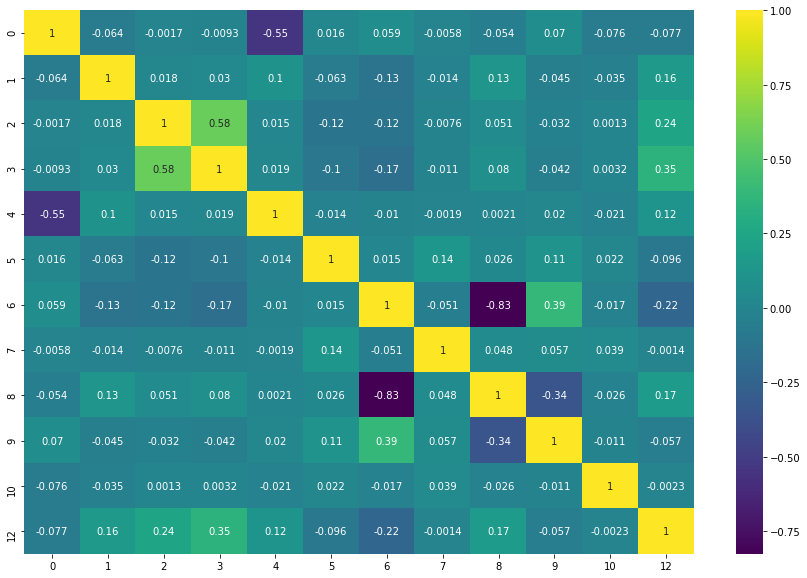

In [11]:
import seaborn as sns
df = df.drop([df.columns[11]], axis = 1)
plt.figure(figsize = (15, 10))
corr = df.corr()
#print(corr)
sns.heatmap(corr, cmap = 'viridis', annot = True)
plt.show()

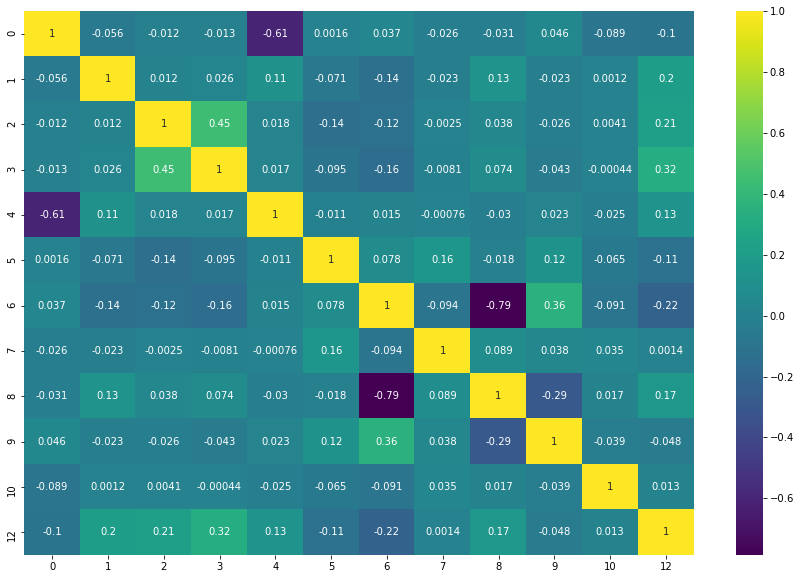

In [12]:
import seaborn as sns
test_df = test_df.drop([test_df.columns[11]], axis = 1)
plt.figure(figsize = (15, 10))
corr = test_df.corr()
#print(corr)
sns.heatmap(corr, cmap = 'viridis', annot = True)
plt.show()

In [13]:
df = df.to_numpy()
test_df = test_df.to_numpy()

In [14]:
# new
inp_num = 11
x = df[:, 0:inp_num]
y = df[:, inp_num]
X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.2, stratify=y, random_state=seed)
x_test = test_df[:, 0:inp_num]
y_test = test_df[:, inp_num]

In [15]:
# DT - depth 5

start = time.time() 

dt_depth5 = DecisionTreeClassifier(max_depth=5, min_samples_leaf=5, random_state=seed)
dt_depth5.fit(x, y)

print("훈련 세트 정확도: {:.3f}".format(dt_depth5.score(x, y)))
#평균 test accuracy
pred_dt = dt_depth5.predict(x_test)
accuracy_dt = []

accuracy_dt.append(accuracy_score(y_test, pred_dt))

print('Accuracy: %.4f' % accuracy_dt[0])
print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt_depth5.feature_importances_))

훈련 세트 정확도: 0.886
Accuracy: 0.8709
time : 29.91570544242859

feature importance: 
[0.00000000e+00 1.15032399e-01 1.30067093e-02 6.40733439e-01
 5.30212278e-02 2.00049457e-03 1.63751386e-01 0.00000000e+00
 1.19722895e-02 0.00000000e+00 4.82054398e-04]


In [16]:
dot_data = export_graphviz(dt_depth5, out_file=None, filled=True, rounded=True, special_characters=True, class_names=["0","1"])
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('original_dt_depth5.png')

True

In [17]:
# DT - depth 6

start = time.time() 

dt_depth6 = DecisionTreeClassifier(max_depth=6, min_samples_leaf=5, random_state=seed)
dt_depth6.fit(x, y)
print("훈련 세트 정확도: {:.3f}".format(dt_depth6.score(x, y)))

pred_dt = dt_depth6.predict(x_test)
accuracy_dt.append(accuracy_score(y_test, pred_dt))

print('Accuracy: %.4f' % accuracy_dt[1])
print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt_depth6.feature_importances_))

훈련 세트 정확도: 0.887
Accuracy: 0.8717
time : 23.232207775115967

feature importance: 
[1.30980677e-03 1.18093664e-01 1.26501314e-02 6.22862716e-01
 5.26019853e-02 1.80011919e-02 1.59184189e-01 0.00000000e+00
 1.19737700e-02 5.92973446e-04 2.72957169e-03]


In [18]:
dot_data = export_graphviz(dt_depth6, out_file=None, filled=True, rounded=True, special_characters=True, class_names=["0","1"])
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('original_dt_depth6.png')

True

In [19]:
# DT - depth 7

start = time.time() 

dt_depth7 = DecisionTreeClassifier(max_depth=7, min_samples_leaf=5, random_state=seed)
dt_depth7.fit(x, y)
print("훈련 세트 정확도: {:.3f}".format(dt_depth7.score(x, y)))

pred_dt = dt_depth7.predict(x_test)
accuracy_dt.append(accuracy_score(y_test, pred_dt))

print('Accuracy: %.4f' % accuracy_dt[2])
print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt_depth7.feature_importances_))

훈련 세트 정확도: 0.887
Accuracy: 0.8713
time : 25.82679057121277

feature importance: 
[0.00176162 0.11717811 0.01719828 0.61219908 0.05427346 0.02162865
 0.15645453 0.         0.01204266 0.00325861 0.004005  ]


In [20]:
dot_data = export_graphviz(dt_depth7, out_file=None, filled=True, rounded=True, special_characters=True, class_names=["0","1"])
graph = pydotplus.graph_from_dot_data(dot_data)
graph.write_png('original_dt_depth7.png')

True

In [21]:
#Test Accuracy 22개 영상
i=1
new_input_num = 12
for data, smp_ratio in  zip(test_V_file_list, test_sampling_ratio_V):
    each_test_df = pd.DataFrame()
    df_class0 = data[data[new_input_num]==0]
    print("0: ", len(df_class0))
    df_class1 = data[data[new_input_num]==1]
    print("1: ", len(df_class1))
    each_test_df = pd.concat([each_test_df, df_class0, df_class1], ignore_index = True)
    print("concat: ", len(each_test_df), '\n')
    each_test_df = each_test_df.drop([each_test_df.columns[11]], axis = 1)
    each_test_df = each_test_df.to_numpy()
    new_inp_num = 11
    each_x_test = each_test_df[:, 0:new_inp_num]
    each_y_test = each_test_df[:, new_inp_num]
    each_pred_dt = dt_depth7.predict(each_x_test)
    evaluation_accuracy = accuracy_score(each_y_test, each_pred_dt) 
    print(str(i)+". "+'Accuracy: %.4f\n' % evaluation_accuracy)
    i=i+1
    del each_pred_dt

0:  90587
1:  18978
concat:  109565 

1. Accuracy: 0.8354

0:  2386
1:  773
concat:  3159 

2. Accuracy: 0.7759

0:  9575
1:  2242
concat:  11817 

3. Accuracy: 0.8248

0:  7800
1:  1889
concat:  9689 

4. Accuracy: 0.8165

0:  28906
1:  1500
concat:  30406 

5. Accuracy: 0.9520

0:  2263
1:  559
concat:  2822 

6. Accuracy: 0.8228

0:  2553
1:  842
concat:  3395 

7. Accuracy: 0.7732

0:  41462
1:  7328
concat:  48790 

8. Accuracy: 0.8578

0:  132454
1:  14323
concat:  146777 

9. Accuracy: 0.9054

0:  10117
1:  3354
concat:  13471 

10. Accuracy: 0.7667

0:  8861
1:  2871
concat:  11732 

11. Accuracy: 0.7758

0:  1903
1:  623
concat:  2526 

12. Accuracy: 0.7724

0:  38617
1:  8421
concat:  47038 

13. Accuracy: 0.8290

0:  91384
1:  16263
concat:  107647 

14. Accuracy: 0.8558

0:  121756
1:  16476
concat:  138232 

15. Accuracy: 0.8844

0:  35040
1:  1169
concat:  36209 

16. Accuracy: 0.9669

0:  14798
1:  4136
concat:  18934 

17. Accuracy: 0.7958

0:  10196
1:  2617
concat:  1

In [22]:
# DT - depth 8

start = time.time() 

dt_depth8 = DecisionTreeClassifier(max_depth=8, min_samples_leaf=5, random_state=seed)
dt_depth8.fit(x, y)
print("훈련 세트 정확도: {:.3f}".format(dt_depth8.score(x, y)))

pred_dt = dt_depth8.predict(x_test)
accuracy_dt.append(accuracy_score(y_test, pred_dt))

print('Accuracy: %.4f' % accuracy_dt[3])
print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt_depth8.feature_importances_))

훈련 세트 정확도: 0.887
Accuracy: 0.8723
time : 28.497607707977295

feature importance: 
[0.00256109 0.11619707 0.01828039 0.60592767 0.05420012 0.0247796
 0.15518364 0.         0.01232939 0.00429826 0.00624278]


In [33]:
#Test Accuracy 22개 영상
i=1
new_input_num = 12
for data, smp_ratio in  zip(test_V_file_list, test_sampling_ratio_V):
    each_test_df = pd.DataFrame()
    df_class0 = data[data[new_input_num]==0]
    print("0: ", len(df_class0))
    df_class1 = data[data[new_input_num]==1]
    print("1: ", len(df_class1))
    each_test_df = pd.concat([each_test_df, df_class0, df_class1], ignore_index = True)
    print("concat: ", len(each_test_df), '\n')
    each_test_df = each_test_df.drop([each_test_df.columns[11]], axis = 1)
    each_test_df = each_test_df.to_numpy()
    new_inp_num = 11
    each_x_test = each_test_df[:, 0:new_inp_num]
    each_y_test = each_test_df[:, new_inp_num]
    each_pred_dt = dt_depth8.predict(each_x_test)
    evaluation_accuracy = accuracy_score(each_y_test, each_pred_dt) 
    print(str(i)+". "+'Accuracy: %.4f\n' % evaluation_accuracy)
    i=i+1
    del each_pred_dt

0:  90587
1:  18978
concat:  109565 

1. Accuracy: 0.8369

0:  2386
1:  773
concat:  3159 

2. Accuracy: 0.7765

0:  9575
1:  2242
concat:  11817 

3. Accuracy: 0.8287

0:  7800
1:  1889
concat:  9689 

4. Accuracy: 0.8148

0:  28906
1:  1500
concat:  30406 

5. Accuracy: 0.9517

0:  2263
1:  559
concat:  2822 

6. Accuracy: 0.8257

0:  2553
1:  842
concat:  3395 

7. Accuracy: 0.7797

0:  41462
1:  7328
concat:  48790 

8. Accuracy: 0.8592

0:  132454
1:  14323
concat:  146777 

9. Accuracy: 0.9057

0:  10117
1:  3354
concat:  13471 

10. Accuracy: 0.7725

0:  8861
1:  2871
concat:  11732 

11. Accuracy: 0.7801

0:  1903
1:  623
concat:  2526 

12. Accuracy: 0.7724

0:  38617
1:  8421
concat:  47038 

13. Accuracy: 0.8323

0:  91384
1:  16263
concat:  107647 

14. Accuracy: 0.8561

0:  121756
1:  16476
concat:  138232 

15. Accuracy: 0.8850

0:  35040
1:  1169
concat:  36209 

16. Accuracy: 0.9668

0:  14798
1:  4136
concat:  18934 

17. Accuracy: 0.7998

0:  10196
1:  2617
concat:  1

In [23]:
# DT - depth 9

start = time.time() 

dt_depth9 = DecisionTreeClassifier(max_depth=9, min_samples_leaf=5, random_state=seed)
dt_depth9.fit(x, y)
print("훈련 세트 정확도: {:.3f}".format(dt_depth9.score(x, y)))

pred_dt = dt_depth9.predict(x_test)
accuracy_dt.append(accuracy_score(y_test, pred_dt))

print('Accuracy: %.4f' % accuracy_dt[4])
print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt_depth9.feature_importances_))

훈련 세트 정확도: 0.887
Accuracy: 0.8723
time : 29.40259075164795

feature importance: 
[2.75483870e-03 1.15529074e-01 1.87680804e-02 6.01821935e-01
 5.38189059e-02 2.78256497e-02 1.54107664e-01 1.41772388e-04
 1.22457301e-02 5.92607273e-03 7.06027794e-03]


In [24]:
# DT - depth 10

start = time.time() 

dt_depth10 = DecisionTreeClassifier(max_depth=10, min_samples_leaf=5, random_state=seed)
dt_depth10.fit(x, y)
print("훈련 세트 정확도: {:.3f}".format(dt_depth10.score(x, y)))

pred_dt = dt_depth10.predict(x_test)
accuracy_dt.append(accuracy_score(y_test, pred_dt))

print('Accuracy: %.4f' % accuracy_dt[5])
print("time :", time.time() - start)

print("\nfeature importance: \n{}".format(dt_depth10.feature_importances_))

훈련 세트 정확도: 0.887
Accuracy: 0.8723
time : 31.359030961990356

feature importance: 
[3.27403911e-03 1.14826447e-01 1.88865735e-02 5.97833627e-01
 5.34728334e-02 3.08604289e-02 1.53197025e-01 2.58338411e-04
 1.22962632e-02 6.65753099e-03 8.43689452e-03]


In [34]:
#Test Accuracy 22개 영상
i=1
new_input_num = 12
for data, smp_ratio in  zip(test_V_file_list, test_sampling_ratio_V):
    each_test_df = pd.DataFrame()
    df_class0 = data[data[new_input_num]==0]
    print("0: ", len(df_class0))
    df_class1 = data[data[new_input_num]==1]
    print("1: ", len(df_class1))
    each_test_df = pd.concat([each_test_df, df_class0, df_class1], ignore_index = True)
    print("concat: ", len(each_test_df), '\n')
    each_test_df = each_test_df.drop([each_test_df.columns[11]], axis = 1)
    each_test_df = each_test_df.to_numpy()
    new_inp_num = 11
    each_x_test = each_test_df[:, 0:new_inp_num]
    each_y_test = each_test_df[:, new_inp_num]
    each_pred_dt = dt_depth10.predict(each_x_test)
    evaluation_accuracy = accuracy_score(each_y_test, each_pred_dt) 
    print(str(i)+". "+'Accuracy: %.4f\n' % evaluation_accuracy)
    i=i+1
    del each_pred_dt

0:  90587
1:  18978
concat:  109565 

1. Accuracy: 0.8366

0:  2386
1:  773
concat:  3159 

2. Accuracy: 0.7797

0:  9575
1:  2242
concat:  11817 

3. Accuracy: 0.8279

0:  7800
1:  1889
concat:  9689 

4. Accuracy: 0.8166

0:  28906
1:  1500
concat:  30406 

5. Accuracy: 0.9522

0:  2263
1:  559
concat:  2822 

6. Accuracy: 0.8218

0:  2553
1:  842
concat:  3395 

7. Accuracy: 0.7779

0:  41462
1:  7328
concat:  48790 

8. Accuracy: 0.8601

0:  132454
1:  14323
concat:  146777 

9. Accuracy: 0.9057

0:  10117
1:  3354
concat:  13471 

10. Accuracy: 0.7736

0:  8861
1:  2871
concat:  11732 

11. Accuracy: 0.7825

0:  1903
1:  623
concat:  2526 

12. Accuracy: 0.7704

0:  38617
1:  8421
concat:  47038 

13. Accuracy: 0.8321

0:  91384
1:  16263
concat:  107647 

14. Accuracy: 0.8558

0:  121756
1:  16476
concat:  138232 

15. Accuracy: 0.8847

0:  35040
1:  1169
concat:  36209 

16. Accuracy: 0.9669

0:  14798
1:  4136
concat:  18934 

17. Accuracy: 0.7994

0:  10196
1:  2617
concat:  1

In [25]:
# SVM
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.preprocessing import PolynomialFeatures

# rf
from sklearn.ensemble import RandomForestClassifier

In [26]:
# SVM - C=1

start = time.time()  # 시작 시간 저장

svm_clf = Pipeline([
                    ("scaler", StandardScaler()),
                    ("linear_svc", LinearSVC(C=1, loss="hinge", random_state=42))
                  ])
svm_clf.fit(x, y)

pred_svm = svm_clf.predict(x_test)
print('Accuracy: %.4f'  % accuracy_score(y_test, pred_svm))

print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

del svm_clf, pred_svm

Accuracy: 0.8653
time : 135.14580154418945


In [27]:
# rf - 5
rf_clf = RandomForestClassifier(n_estimators=5, random_state=42)
rf_clf.fit(x, y)

pred_rf = rf_clf.predict(x_test)
print('Accuracy: %.4f'  % accuracy_score(y_test, pred_rf))

del rf_clf, pred_rf

Accuracy: 0.8676


In [28]:
# rf - 6
rf_clf = RandomForestClassifier(n_estimators=6, random_state=42)
rf_clf.fit(x, y)

pred_rf = rf_clf.predict(x_test)
print('Accuracy: %.4f'  % accuracy_score(y_test, pred_rf))

del rf_clf, pred_rf

Accuracy: 0.8677


In [29]:
# rf - 7
rf_clf = RandomForestClassifier(n_estimators=7, random_state=42)
rf_clf.fit(x, y)

pred_rf = rf_clf.predict(x_test)
print('Accuracy: %.4f'  % accuracy_score(y_test, pred_rf))

del rf_clf, pred_rf

Accuracy: 0.8677


In [30]:
# rf - 8
rf_clf = RandomForestClassifier(n_estimators=8, random_state=42)
rf_clf.fit(x, y)

pred_rf = rf_clf.predict(x_test)
print('Accuracy: %.4f'  % accuracy_score(y_test, pred_rf))

del rf_clf, pred_rf

Accuracy: 0.8679


In [31]:
# rf - 9
rf_clf = RandomForestClassifier(n_estimators=9, random_state=42)
rf_clf.fit(x, y)

pred_rf = rf_clf.predict(x_test)
print('Accuracy: %.4f'  % accuracy_score(y_test, pred_rf))

del rf_clf, pred_rf

Accuracy: 0.8677
